In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
#pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
'''postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'fifa19'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
fifa19 = pd.read_sql_query('select * from fifa19',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()'''


"postgres_user = 'dsbc_student'\npostgres_pw = '7*.8G9QH21'\npostgres_host = '142.93.121.174'\npostgres_port = '5432'\npostgres_db = 'fifa19'\n\nengine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(\n    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))\nfifa19 = pd.read_sql_query('select * from fifa19',con=engine)\n\n# no need for an open connection, as we're only doing a single query\nengine.dispose()"

In [3]:
fifa19 = pd.read_csv('/Users/richardlafferty/Downloads/fifa19.csv')

In [4]:
fifa19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [5]:
display(fifa19.head())

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## I am going to be looking to make run a regression which will let me find with reasonabel accuracy, the value of a player in regards to his salary. My goal is to find the most pertinent variables and to use this on my next fantasy draft.

In [6]:
fifa19.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [7]:
# I think some of these are inconsequential to us and I'll drop them now
fifa19 = fifa19.drop(['Photo', 'Flag', 'Club Logo', 'ID',
                      'Jersey Number', 'Real Face', 
                      'Contract Valid Until', 'Joined'], axis=1)

In [8]:
#list of numeric columns
cont_columns = list(fifa19.select_dtypes(exclude='object'))
cat_columns = list(fifa19.select_dtypes('object'))
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
['Name', 'Nationality', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Release Clause']


In [9]:
fifa19.head()

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
fifa19.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause'],
   

In [11]:
#looking at null values
print((fifa19.isnull().sum().sort_values(ascending=False)))

Loaned From        16943
RWB                 2085
LM                  2085
CB                  2085
LCB                 2085
LB                  2085
RDM                 2085
CDM                 2085
LDM                 2085
LWB                 2085
RM                  2085
RCM                 2085
CM                  2085
LCM                 2085
RAM                 2085
RB                  2085
CAM                 2085
LAM                 2085
RW                  2085
RF                  2085
CF                  2085
LF                  2085
LW                  2085
RS                  2085
ST                  2085
LS                  2085
RCB                 2085
Release Clause      1564
Club                 241
Position              60
                   ...  
Interceptions         48
SprintSpeed           48
Volleys               48
ShortPassing          48
HeadingAccuracy       48
Finishing             48
Crossing              48
Aggression            48
LongPassing           48


In [12]:
#dropping loaned from because it's missing over 90% of its data unsurprisingly
fifa19 = fifa19.drop(['Loaned From'], axis=1)

In [13]:
fifa19.loc[fifa19.CDM.isnull()]
#so there are some pretty important players missing these values. I would hate to lose that data
#I'll have to interpolate the nulls

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,€58M,€240K,1328,...,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,€123.3M
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,€53.5M,€240K,1311,...,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,€38M,€130K,1473,...,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,€62.7M
37,37,H. Lloris,31,France,88,88,Tottenham Hotspur,€36M,€150K,1335,...,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0,€66.6M
40,40,S. Handanovič,33,Slovenia,88,88,Inter,€30M,€110K,1262,...,69.0,25.0,10.0,13.0,87.0,86.0,69.0,89.0,89.0,€51M
41,41,G. Buffon,40,Italy,88,88,Paris Saint-Germain,€4M,€77K,1334,...,70.0,13.0,11.0,11.0,88.0,87.0,74.0,90.0,83.0,€7.4M
46,46,K. Navas,31,Costa Rica,87,87,Real Madrid,€30.5M,€195K,1345,...,67.0,28.0,14.0,14.0,90.0,81.0,75.0,82.0,90.0,€62.5M
57,57,Ederson,24,Brazil,86,90,Manchester City,€41.5M,€125K,1463,...,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0,€79.9M


In [14]:
fifa19.CDM.value_counts()

62+2    660
61+2    620
60+2    620
59+2    592
64+2    592
63+2    573
58+2    565
65+2    539
57+2    529
66+2    524
56+2    520
54+2    505
55+2    479
53+2    471
51+2    468
49+2    448
52+2    444
50+2    438
68+2    428
48+2    427
67+2    426
47+2    396
69+2    362
46+2    359
44+2    339
45+2    325
70+2    302
43+2    282
71+2    271
42+2    239
       ... 
71+3      8
62+3      7
57+3      6
53+3      6
69+3      6
63+3      6
52+3      6
66+3      6
51+3      5
81+2      5
79+3      5
54+3      4
29+2      4
65+3      4
64+3      4
67+3      4
68+3      3
45+3      2
84+3      2
50+3      2
49+3      2
87+3      1
57+4      1
83+2      1
28+2      1
85+3      1
46+3      1
68+5      1
82+2      1
86+3      1
Name: CDM, Length: 99, dtype: int64

In [15]:
#all these columns have a + value added, which according to soccer friends is not important 
cols = ["LS", "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM", "LCM",
        "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB", "CB", "RCB", "RB"]
for col in cols:
    fifa19[col] = fifa19[col].str[:-2]
    fifa19[col] = fifa19[col].astype(float)

In [16]:
print(fifa19['Height'].head())
print(fifa19['Height'].isnull().sum())
fifa19['Height'].dropna(inplace=True)

0     5'7
1     6'2
2     5'9
3     6'4
4    5'11
Name: Height, dtype: object
48


In [17]:
def parse_height(ht):
    height = ht.split("'")
    #print(height) #used this to see my output after splitting
    feet = float(height[0])
    inches = float(height[1])
    return (12*feet) + inches
fifa19['Height'] = fifa19['Height'].apply(lambda x: parse_height(x))


In [18]:
#Correct Weight
fifa19['Weight']=fifa19['Weight'].str[:-3]
fifa19['Weight']=fifa19['Weight'].astype(float)

print(fifa19.Height.head())
print(fifa19.Weight.head())


0    67.0
1    74.0
2    69.0
3    76.0
4    71.0
Name: Height, dtype: float64
0    159.0
1    183.0
2    150.0
3    168.0
4    154.0
Name: Weight, dtype: float64


In [19]:
display(fifa19.head(200))

,Unnamed: 0,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,5,E. Hazard,27,Belgium,91,91,Chelsea,€93M,€340K,2142,...,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M
6,6,L. Modrić,32,Croatia,91,91,Real Madrid,€67M,€420K,2280,...,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,€137.4M
7,7,L. Suárez,31,Uruguay,91,91,FC Barcelona,€80M,€455K,2346,...,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,€164M
8,8,Sergio Ramos,32,Spain,91,91,Real Madrid,€51M,€380K,2201,...,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,€104.6M
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,€68M,€94K,1331,...,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,€144.5M


those are some pretty fine distributions. A few categorical variables snuck in though so I'll make a new list of just continuous variables.

In [20]:
cont_columns = [i for i in cont_columns if i not in('International Reputation', 'Weak Foot', 'Skill Moves')]
print(cont_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


In [21]:
add_list = ['International Reputation', 'Weak Foot', 'Skill Moves']
cat_columns = cat_columns + add_list

In [22]:
print(cat_columns)

['Name', 'Nationality', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Release Clause', 'International Reputation', 'Weak Foot', 'Skill Moves']


In [23]:
print(cont_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


In [24]:
fifa19.Value.tail(1000)

17207    €140K
17208    €190K
17209     €10K
17210     €70K
17211    €170K
17212    €100K
17213    €100K
17214    €180K
17215       €0
17216     €90K
17217    €140K
17218    €150K
17219    €120K
17220    €180K
17221    €160K
17222    €140K
17223    €180K
17224     €90K
17225    €190K
17226    €100K
17227    €140K
17228    €180K
17229    €160K
17230    €120K
17231    €120K
17232    €160K
17233    €100K
17234    €200K
17235    €160K
17236    €110K
         ...  
18177     €70K
18178     €50K
18179     €50K
18180     €40K
18181     €50K
18182     €50K
18183       €0
18184     €40K
18185     €50K
18186     €60K
18187     €40K
18188     €60K
18189     €60K
18190     €60K
18191     €50K
18192     €50K
18193     €50K
18194     €50K
18195     €60K
18196     €60K
18197     €60K
18198     €60K
18199     €70K
18200     €60K
18201     €60K
18202     €60K
18203     €60K
18204     €60K
18205     €60K
18206     €60K
Name: Value, Length: 1000, dtype: object

In [25]:
#changing all currency columns into float columns to help analyze

curs=["Release Clause", "Value", "Wage"]
for cur in curs:
    
    def curr_value(x):
        x = str(x).replace('€', '')
        if('M' in str(x)):
            x = str(x).replace('M', '')
            x = float(x) * 1000000
        elif('K' in str(x)):
            x = str(x).replace('K', '')
            x = float(x) * 1000
        return float(x)
    fifa19[cur] = fifa19[cur].apply(curr_value)

In [26]:
cont_columns = cont_columns + curs
cat_columns = ['Name', 'Nationality', 'Club', 'Preferred Foot',
               'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight',
               'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
               'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB',
               'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
               'International Reputation', 'Weak Foot', 'Skill Moves']

In [27]:
print(cont_columns)
print(cat_columns)

['Unnamed: 0', 'Age', 'Overall', 'Potential', 'Special', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause', 'Value', 'Wage']
['Name', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position', 'Loaned From', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'International Reputation', 'Weak Foot', 'Skill Moves']


In [28]:
#looking at our target variable
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
inf


In [29]:
#having an inf value will certainly mess up our model so I will try to take care of it now
fifa19.value_overall = fifa19.value_overall.replace(np.inf, np.nan)
print(fifa19.value_overall.max())
print(fifa19.value_overall.isnull().sum())
#if we only have 252 null values then I feel ok with just dropping those rows
print(fifa19.value_overall.head())



0.006
252
0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64


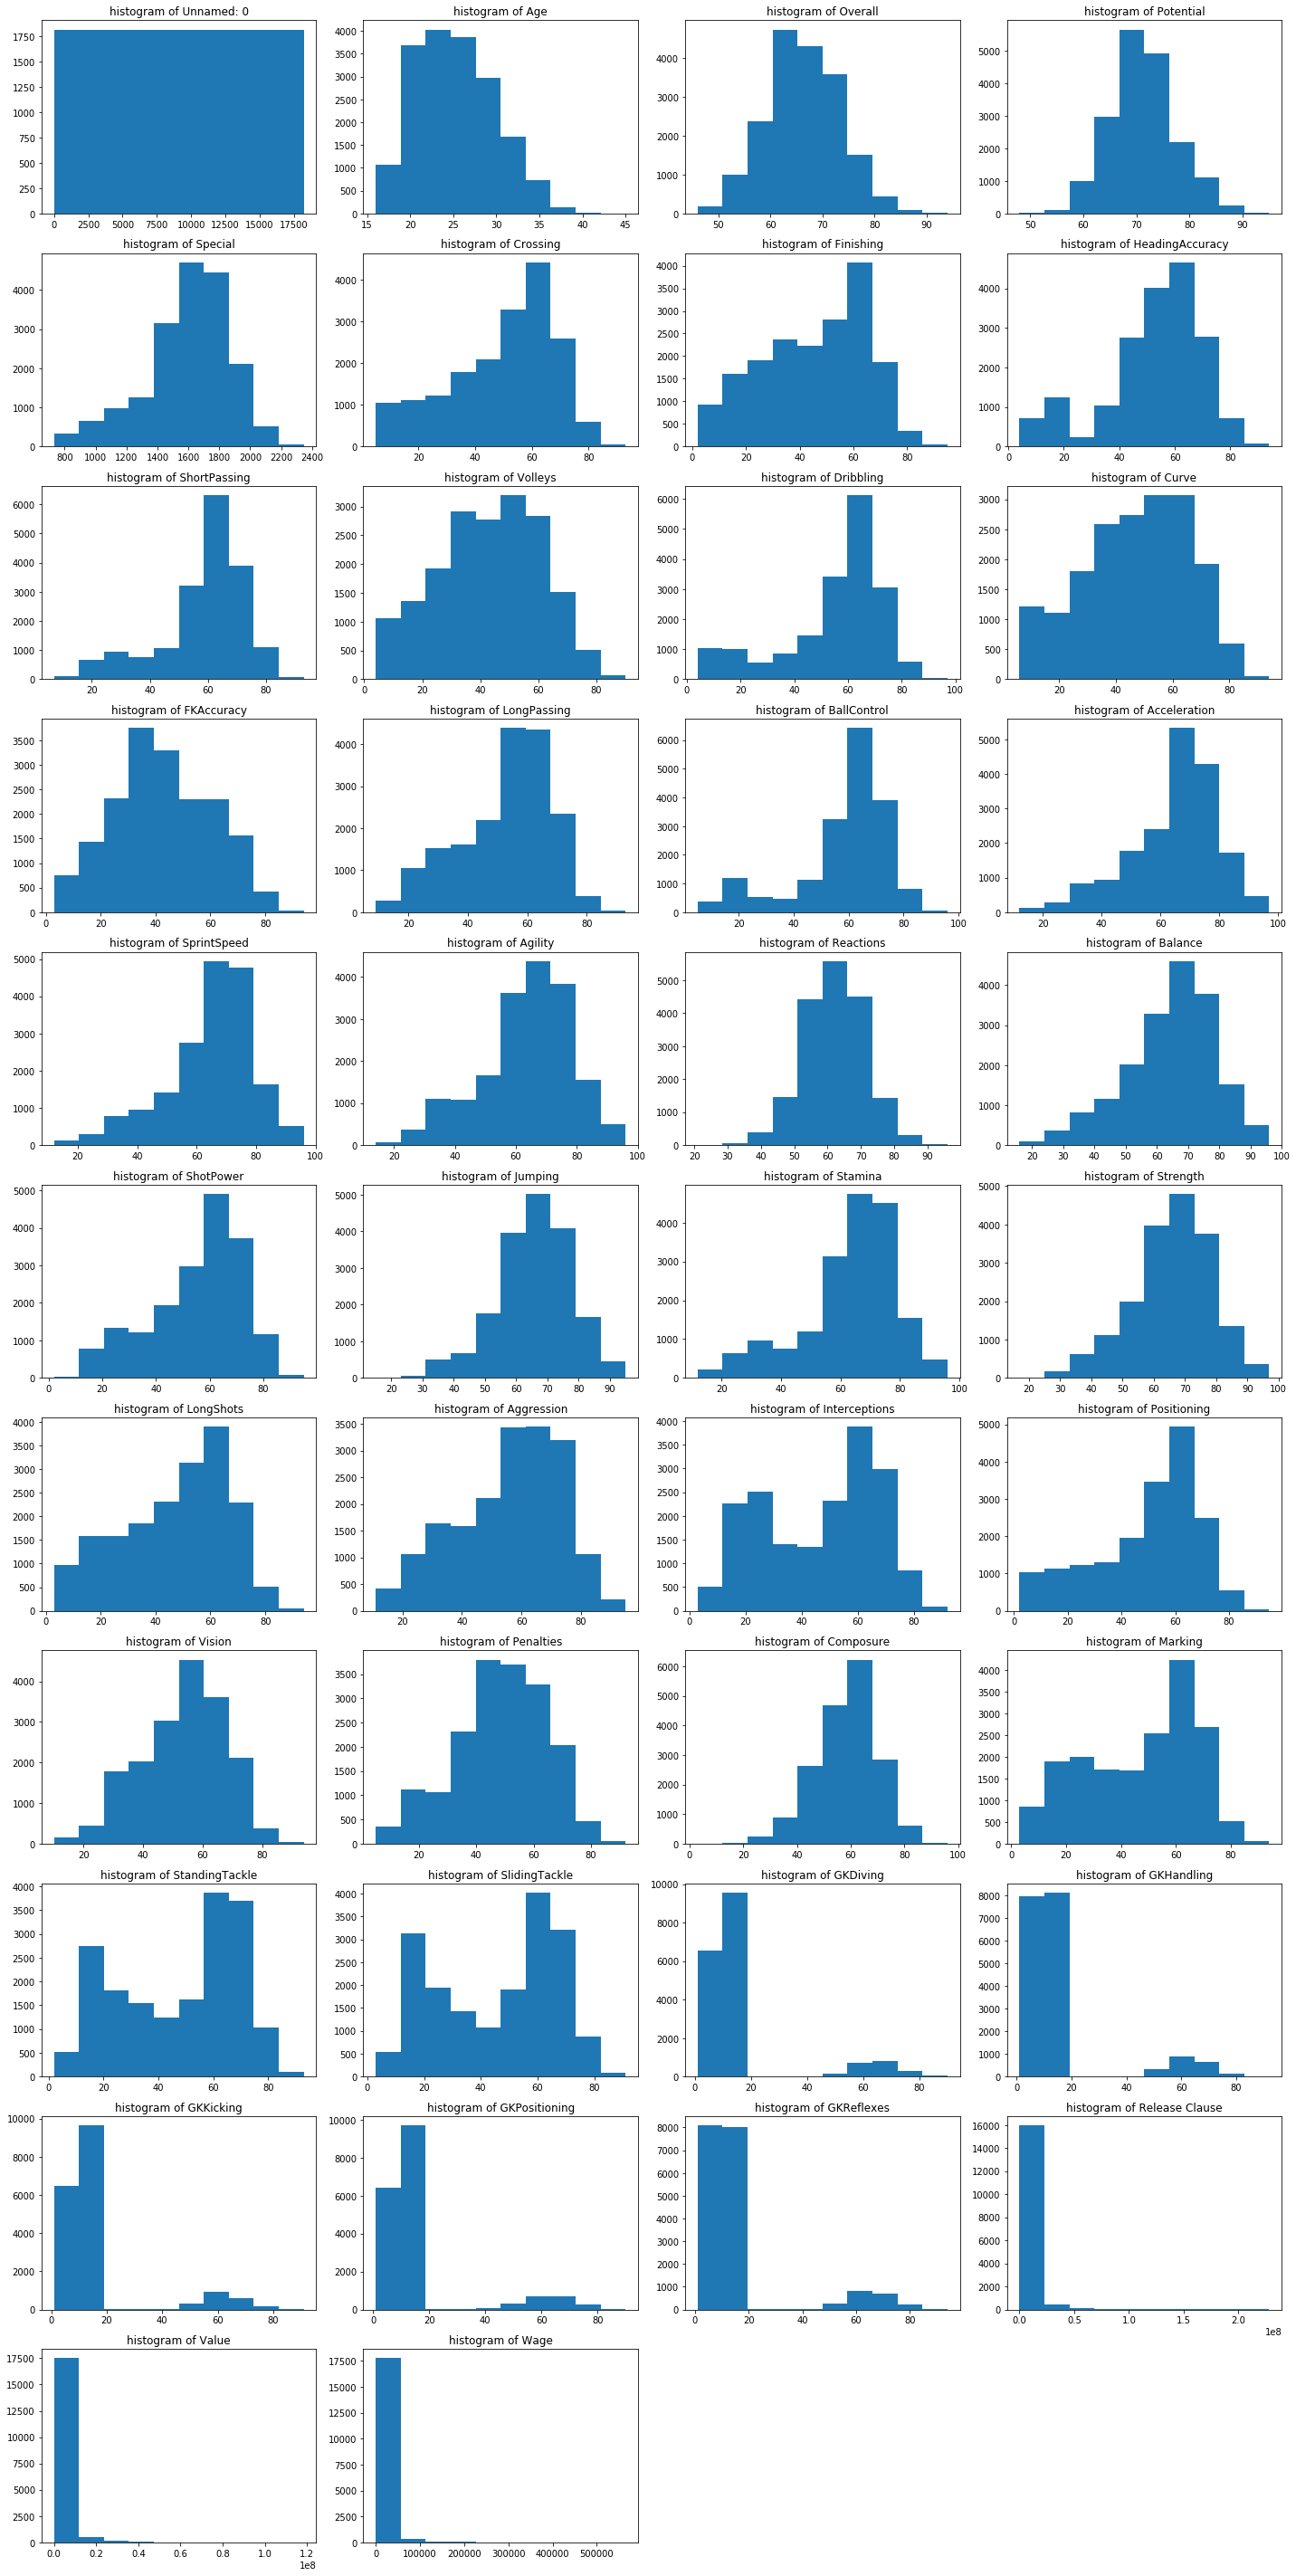

In [30]:
fig = plt.figure(figsize=(20,150))
for i, col in enumerate(cont_columns):
    
    plt.subplot(len(cont_columns), 4, i+1)
    plt.hist(fifa19[col])
    plt.title('histogram of {}'.format(col))
    plt.tight_layout()

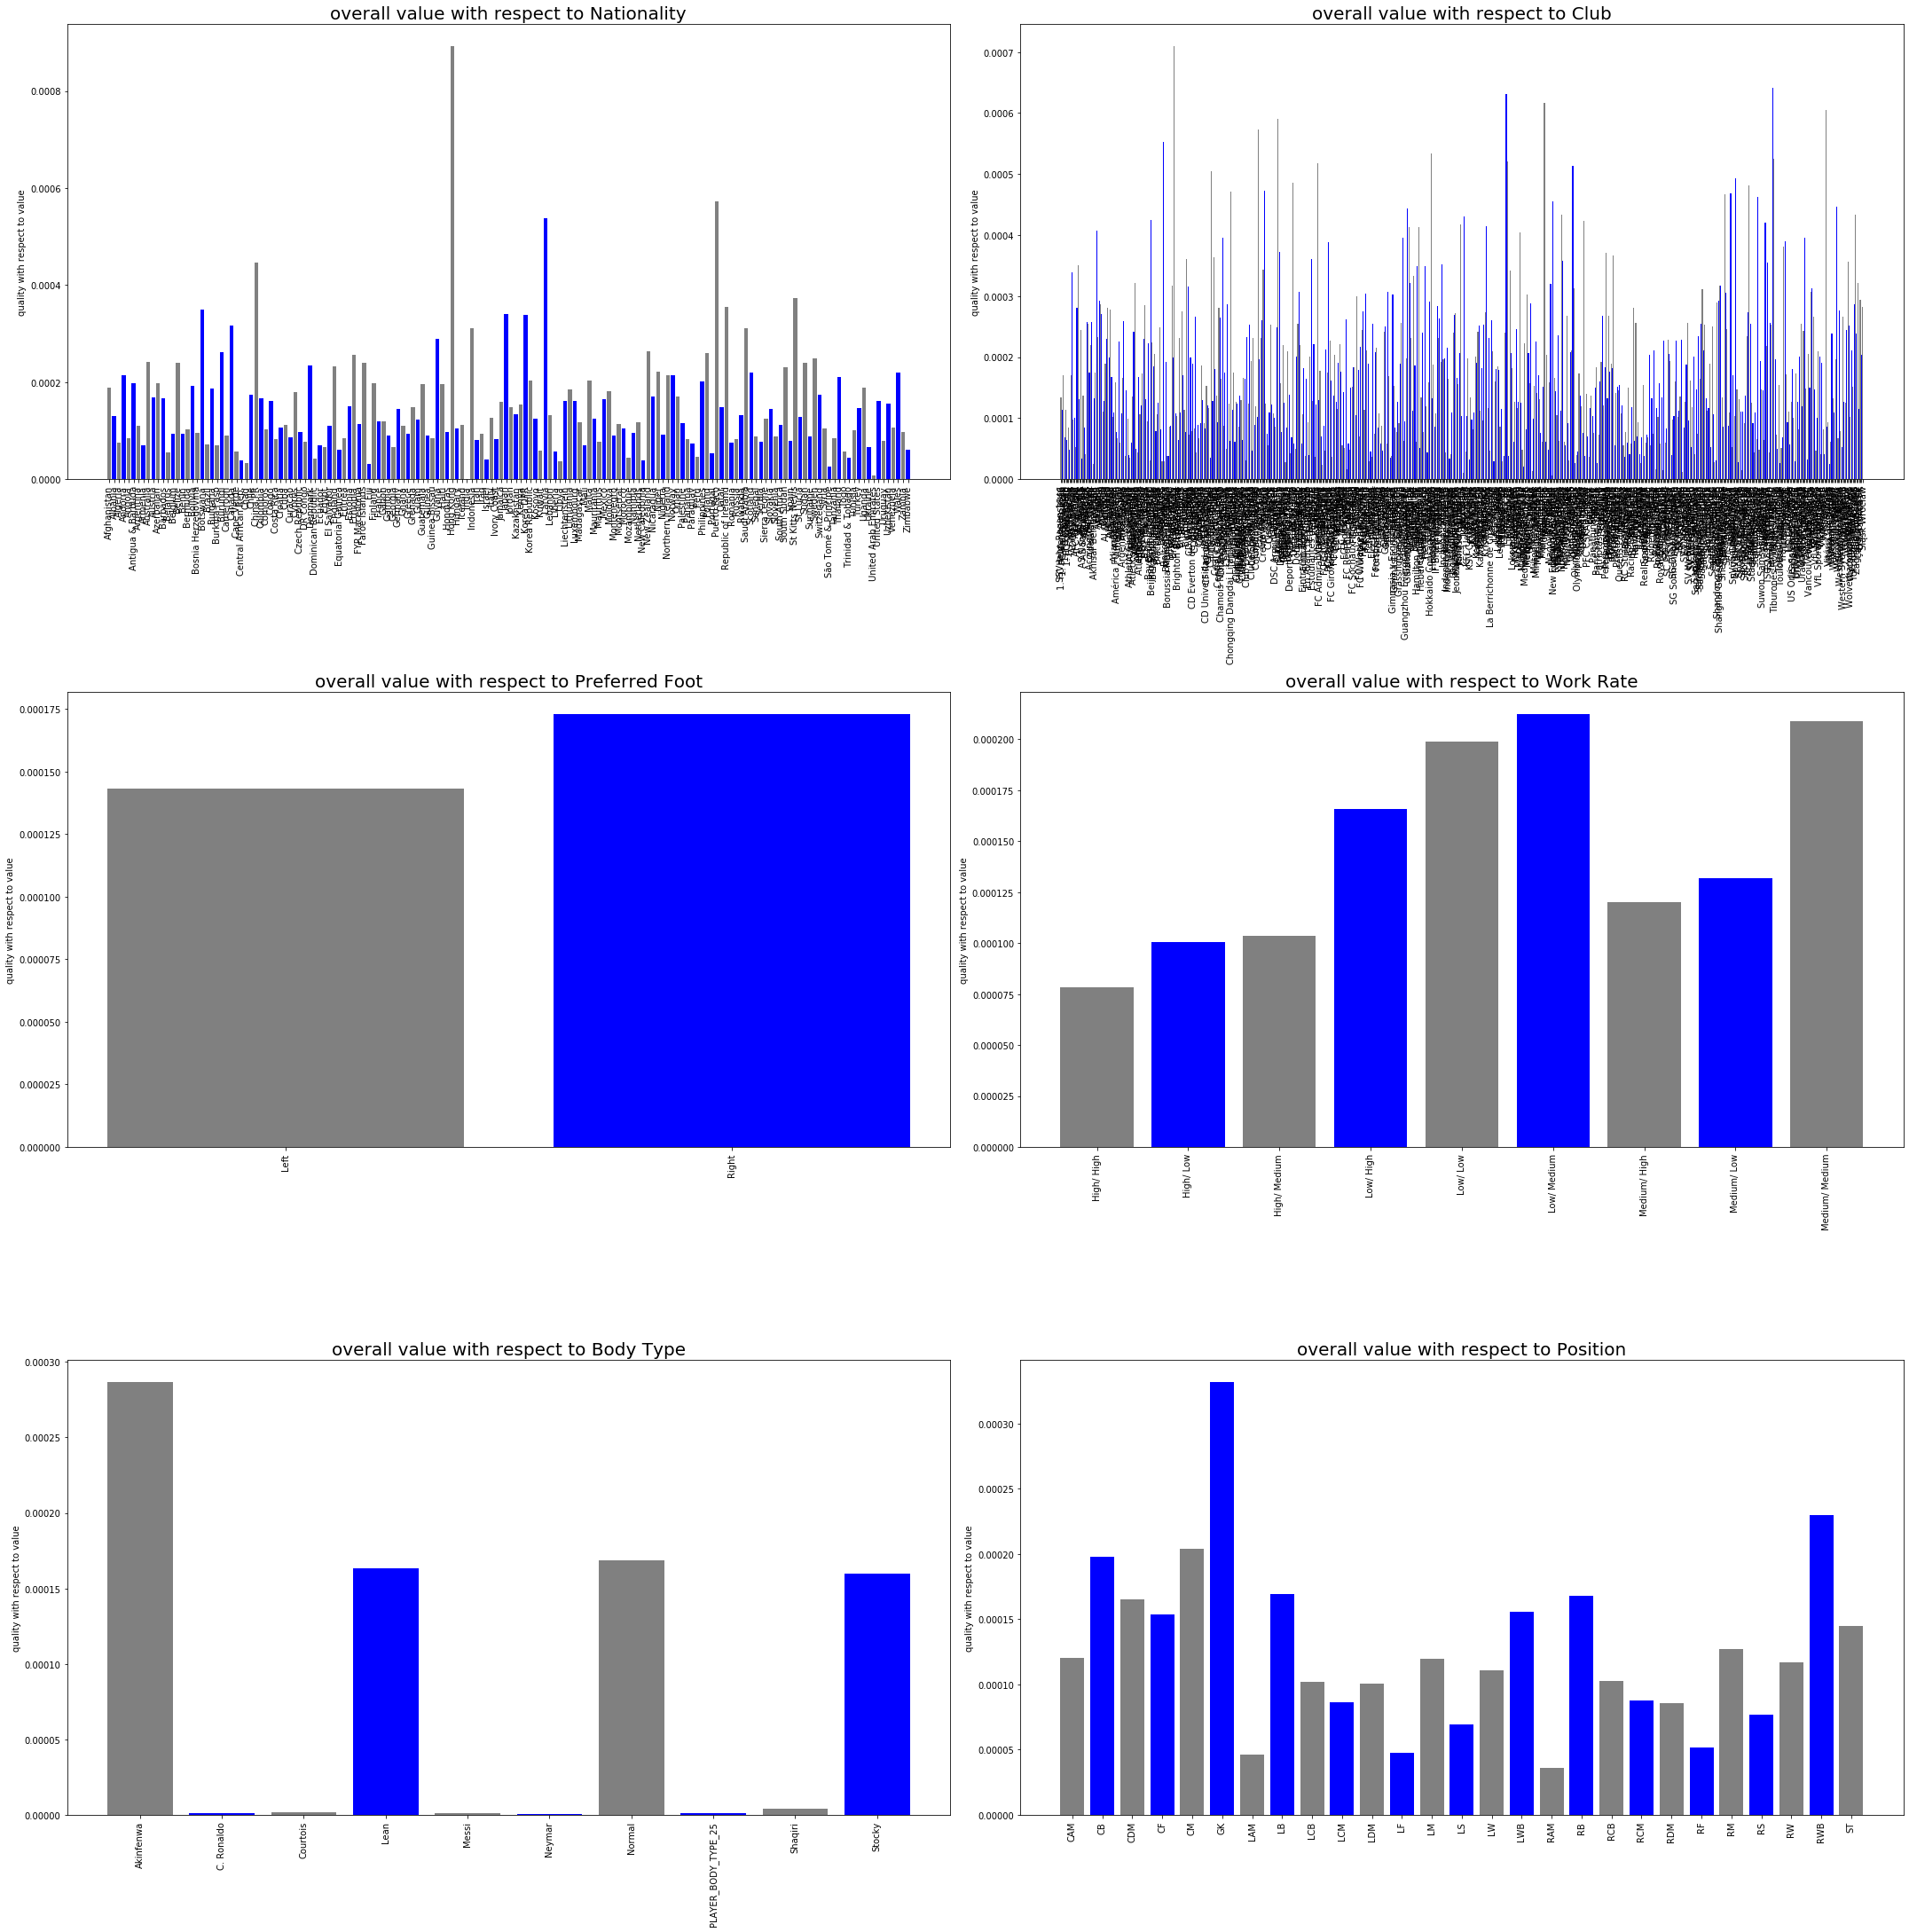

In [31]:
object_columns = ['Nationality',
                  'Club',
                  'Preferred Foot',
                  'Work Rate',
                  'Body Type',
                  'Position']

plt.figure(figsize=(30, 60))
for i, col in enumerate(object_columns):
    plt.subplot(len(object_columns), 2, i+1)
    plt.bar(fifa19.groupby(col)['value_overall'].mean(
    ).index, fifa19.groupby(col)['value_overall'].mean(), color=('grey', 'blue'))
    plt.ylabel('quality with respect to value')
    plt.xticks(rotation='vertical')
    plt.title('overall value with respect to {}'.format(col), fontsize=20)
    plt.tight_layout()
    #there's a lot of noise in the Nationality and Club

In [32]:
fifa19.drop(columns=['Nationality'])
# I obviously need to deal with my nulls. I don't necessarily want to just drop them all so I'll check my options
obj_df = fifa19.select_dtypes(include=['object']).copy()
#Encoding &missing Values
cols=obj_df.columns
for col in cols:
    print(col)
    fifa19[col].replace(np.NaN,'NotAv',inplace=True)
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    labelencoder_X = LabelEncoder()
    fifa19[col] = labelencoder_X.fit_transform(fifa19[col])

Name
Nationality
Club
Preferred Foot
Work Rate
Body Type
Position


In [33]:
fifa19.isnull().sum().sort_values(ascending=False)

LB                 2085
RB                 2085
CB                 2085
LCB                2085
RWB                2085
RDM                2085
CDM                2085
LDM                2085
LWB                2085
RM                 2085
RCM                2085
CM                 2085
LCM                2085
LM                 2085
RAM                2085
CAM                2085
LAM                2085
RW                 2085
RF                 2085
CF                 2085
LF                 2085
LW                 2085
RS                 2085
ST                 2085
LS                 2085
RCB                2085
Release Clause     1564
value_overall       252
FKAccuracy           48
Aggression           48
                   ... 
Dribbling            48
Volleys              48
ShortPassing         48
Strength             48
HeadingAccuracy      48
Finishing            48
LongPassing          48
Crossing             48
Acceleration         48
SprintSpeed          48
Agility         

In [34]:
fifa19['value_overall'].isnull().sum()
print(len(fifa19['value_overall']))
print(len(fifa19))

18207
18207


In [35]:
#I will fill these null values using interpolation
#fifa19['value_overall'].dropna(inplace=True)
fifa19 = fifa19.interpolate()

In [36]:
fifa19['value_overall'] = fifa19['Overall'] / fifa19['Value']
fifa19 = fifa19.replace([np.inf, -np.inf], np.nan)

print(fifa19.isnull().sum().sort_values(ascending=False))


value_overall      252
RWB                  0
RS                   0
LW                   0
LF                   0
CF                   0
RF                   0
RW                   0
LAM                  0
CAM                  0
RAM                  0
LM                   0
LCM                  0
CM                   0
RCM                  0
RM                   0
LWB                  0
LDM                  0
CDM                  0
ST                   0
LS                   0
Weight               0
Wage                 0
Name                 0
Age                  0
Nationality          0
Overall              0
Potential            0
Club                 0
Value                0
                  ... 
Composure            0
Marking              0
StandingTackle       0
SlidingTackle        0
GKDiving             0
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Jumping              0
ShotPower            0
Balance              0
Volleys    

In [37]:
fifa19.dropna(inplace=True)

## All null and inf values have been taken care of and now I can start dealing with outliers

In [38]:
print(len(fifa19))

17955


In [39]:
cont_columns = ['Unnamed: 0', 'Age', 'Overall',
                  'Potential', 'Special', 'Crossing',
                  'Finishing', 'HeadingAccuracy', 'ShortPassing',
                  'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                  'LongPassing', 'BallControl', 'Acceleration',
                  'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                  'ShotPower', 'Jumping', 'Stamina', 'Strength',
                  'LongShots', 'Aggression', 'Interceptions',
                  'Positioning', 'Vision', 'Penalties', 'Composure',
                  'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
                  'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
                  'Release Clause', 'Value', 'Wage', 'LS', 'Weight', 'RCM', 'RWB']
#cont_columns = fifa19.select_dtypes(exclude='object')
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                              len((np.where((fifa19[col] > max_val) |
                                                                                            (fifa19[col] < min_val))[0])), len((np.where((fifa19[col] > max_val) |
                                                                                                                                              (fifa19[col] < min_val))[0]))*100/17955))
   

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
Number of outliers and percentage of it in Age : 35 and %0.1949317738791423
Number of outliers and percentage of it in Overall : 162 and %0.9022556390977443
Number of outliers and percentage of it in Potential : 156 and %0.8688387635756056
Number of outliers and percentage of it in Special : 545 and %3.03536619326093
Number of outliers and percentage of it in Crossing : 0 and %0.0
Number of outliers and percentage of it in Finishing : 0 and %0.0
Number of outliers and percentage of it in HeadingAccuracy : 1413 and %7.869674185463659
Number of outliers and percentage of it in ShortPassing : 1694 and %9.434697855750487
Number of outliers and percentage of it in Volleys : 0 and %0.0
Number of outliers and percentage of it in Dribbling : 1891 and %10.531885268727374
Number of outliers and percentage of it in Curve : 0 and %0.0
Number of outliers and percentage of it in FKAccuracy : 1 and %0.00556947925368978
Number of outli

In [40]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0])),len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0]))*100/17955))
    
    
    print('percent of outliers low')
    print(len(np.where(fifa19[col] < min_val)[0]) /17955)
    print('Percent of outliers high')
    print(len(np.where(fifa19[col] > max_val)[0]) /17955)
    print(90 * '-')

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Age : 35 and %0.1949317738791423
percent of outliers low
0.0
Percent of outliers high
0.001949317738791423
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Overall : 162 and %0.9022556390977443
percent of outliers low
0.0028961292119186856
Percent of outliers high
0.006126427179058758
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Potential : 156 and %0.8688387635756056
percent of outliers low
0.001392369813422445
Percent of outliers high
0.007296017822333612
------------------------------------------------------------------------------------------
Number of outli

Number of outliers and percentage of it in Wage : 2031 and %11.311612364243944
percent of outliers low
0.0
Percent of outliers high
0.11311612364243943
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in LS : 20 and %0.1113895850737956
percent of outliers low
0.0001113895850737956
Percent of outliers high
0.0010025062656641604
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Weight : 74 and %0.4121414647730437
percent of outliers low
0.0007240323029796714
Percent of outliers high
0.0033973823447507657
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in RCM : 59 and %0.328599275967697
percent of outliers low
0.0020050125313283208
Percent of outliers high
0.0012809802283486494
-------------------------------------------------------------------

In [41]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    fifa19[col] = winsorize(fifa19[col], (len(np.where(fifa19[col] < min_val)[0]) / 17955,
                                          len(np.where(fifa19[col] > max_val)[
                                              0]) / 17955
                                          )
                            )

In [42]:
for col in cont_columns:
    q75, q25 = np.percentile(fifa19[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0])),len((np.where((fifa19[col] > max_val) | 
                                                                                           (fifa19[col] < min_val))[0]))*100/17955))
    
    
    print('percent of outliers low')
    print(len(np.where(fifa19[col] < min_val)[0]) /17955)
    print('Percent of outliers high')
    print(len(np.where(fifa19[col] > max_val)[0]) /17955)
    print(90 * '-')

Number of outliers and percentage of it in Unnamed: 0 : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Age : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Overall : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Potential : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Special : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------

Number of outliers and percentage of it in RCM : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in RWB : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------


In [43]:
fifa19['Release Clause'] = winsorize(fifa19['Release Clause'], (0, .144))


In [44]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
y = fifa19['value_overall']
print(fifa19['value_overall'].head())
print(fifa19['value_overall'].min())
print(fifa19['value_overall'].max())

0    8.506787e-07
1    1.220779e-06
2    7.763713e-07
3    1.263889e-06
4    8.921569e-07
Name: value_overall, dtype: float64
7.763713080168777e-07
0.006


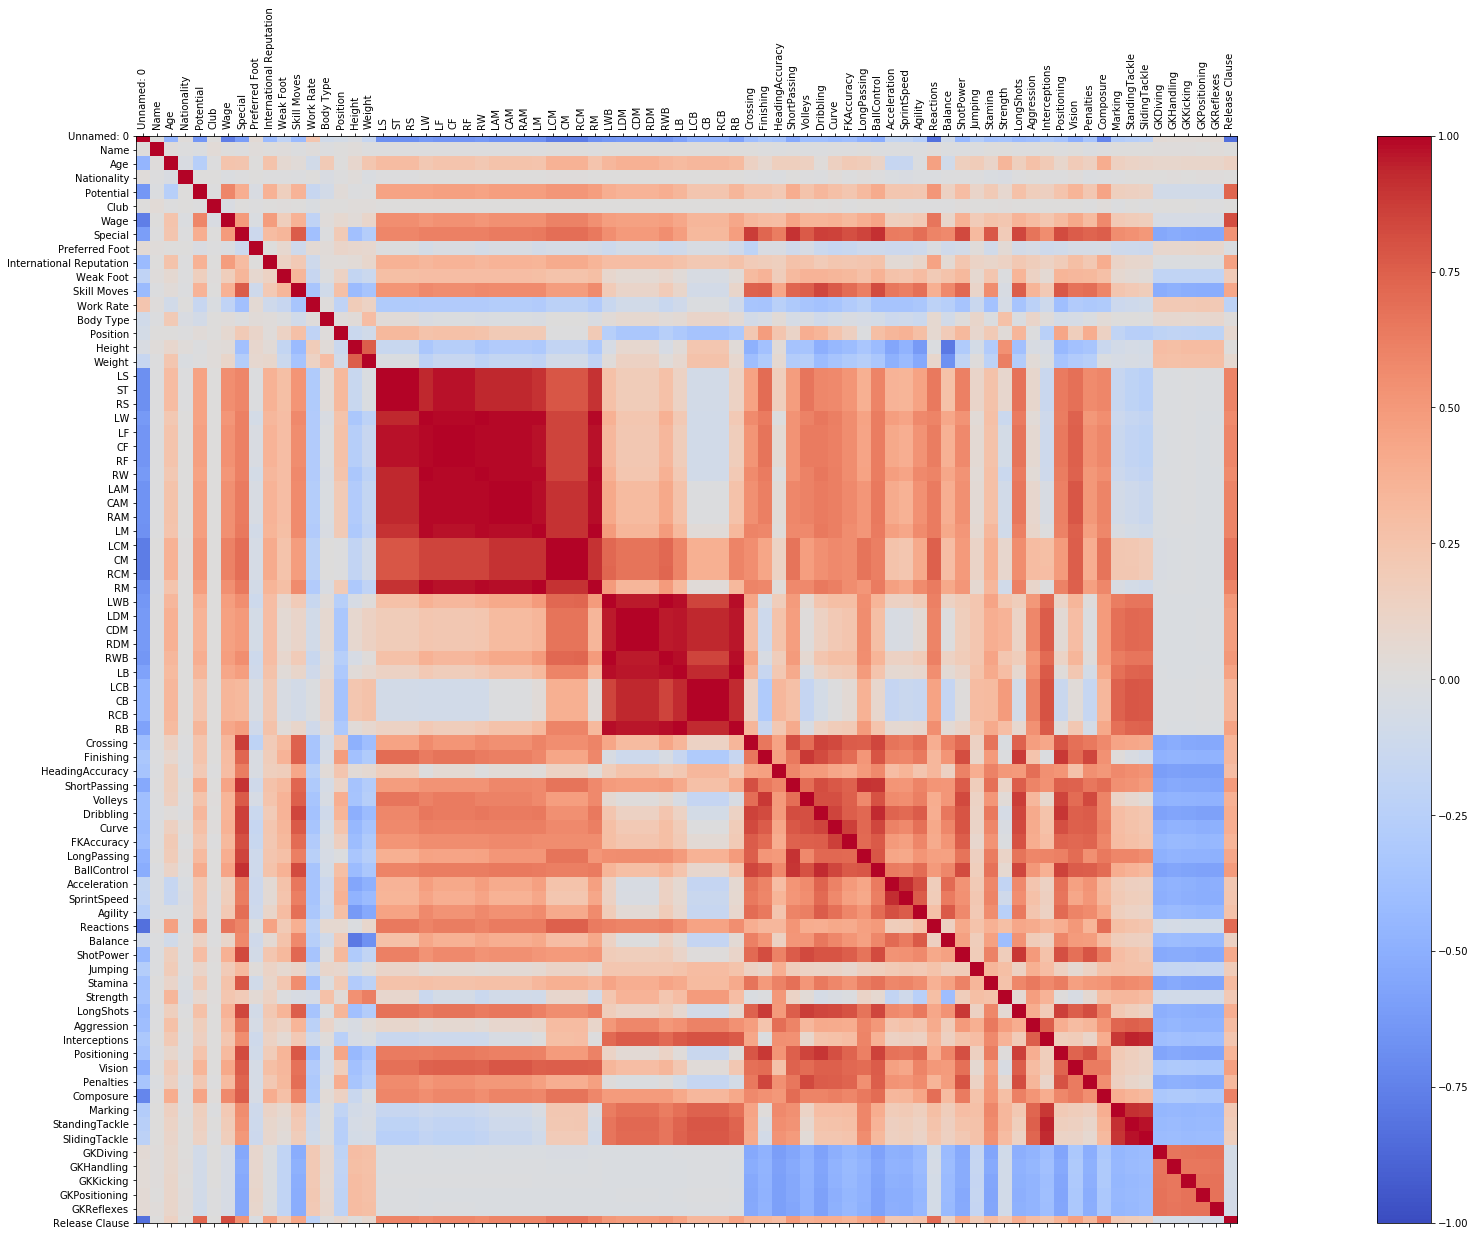

In [45]:
#Now that null values are taken care of I'll look into correlation between
#variables to determine which variables are less important
corr = X.corr()
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

In [46]:
#removing any variables that are too highly correlated
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
#looking at this I'll make a new heatmap with these variables to see what I'll drop

['ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'ShortPassing', 'BallControl', 'SprintSpeed', 'StandingTackle', 'SlidingTackle']


In [47]:
drop_list = ['Skill Moves', 'Weight', 'ST', 'RS', 'LW', 'LF', 
              'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 
              'CM', 'RCM', 'RM', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 
              'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'ShortPassing', 
              'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 
              'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 
              'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 
              'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 
              'StandingTackle', 'SlidingTackle', 'Release Clause', 'value_overall']

In [48]:

print(np.abs(fifa19[drop_list].iloc[:, :].corr(
).loc[:, 'value_overall'].sort_values(ascending=True))
)
# looking at corr of variables that could be dropped

CM                0.444650
LCM               0.444650
RCM               0.443986
Composure         0.419594
LM                0.412065
RM                0.412065
Release Clause    0.411284
BallControl       0.410225
RS                0.408459
ST                0.408459
LAM               0.403328
CAM               0.403328
RAM               0.403328
ShortPassing      0.399437
CF                0.397691
RF                0.397691
LF                0.397691
RW                0.387101
LW                0.387101
RWB               0.355480
ShotPower         0.349489
Dribbling         0.349382
LongPassing       0.344720
Stamina           0.334662
LongShots         0.331537
RDM               0.328662
CDM               0.328662
LDM               0.328662
Vision            0.327935
Skill Moves       0.326340
Curve             0.319373
Crossing          0.314446
LB                0.311926
RB                0.311926
Positioning       0.311530
Volleys           0.306651
Penalties         0.289677
S

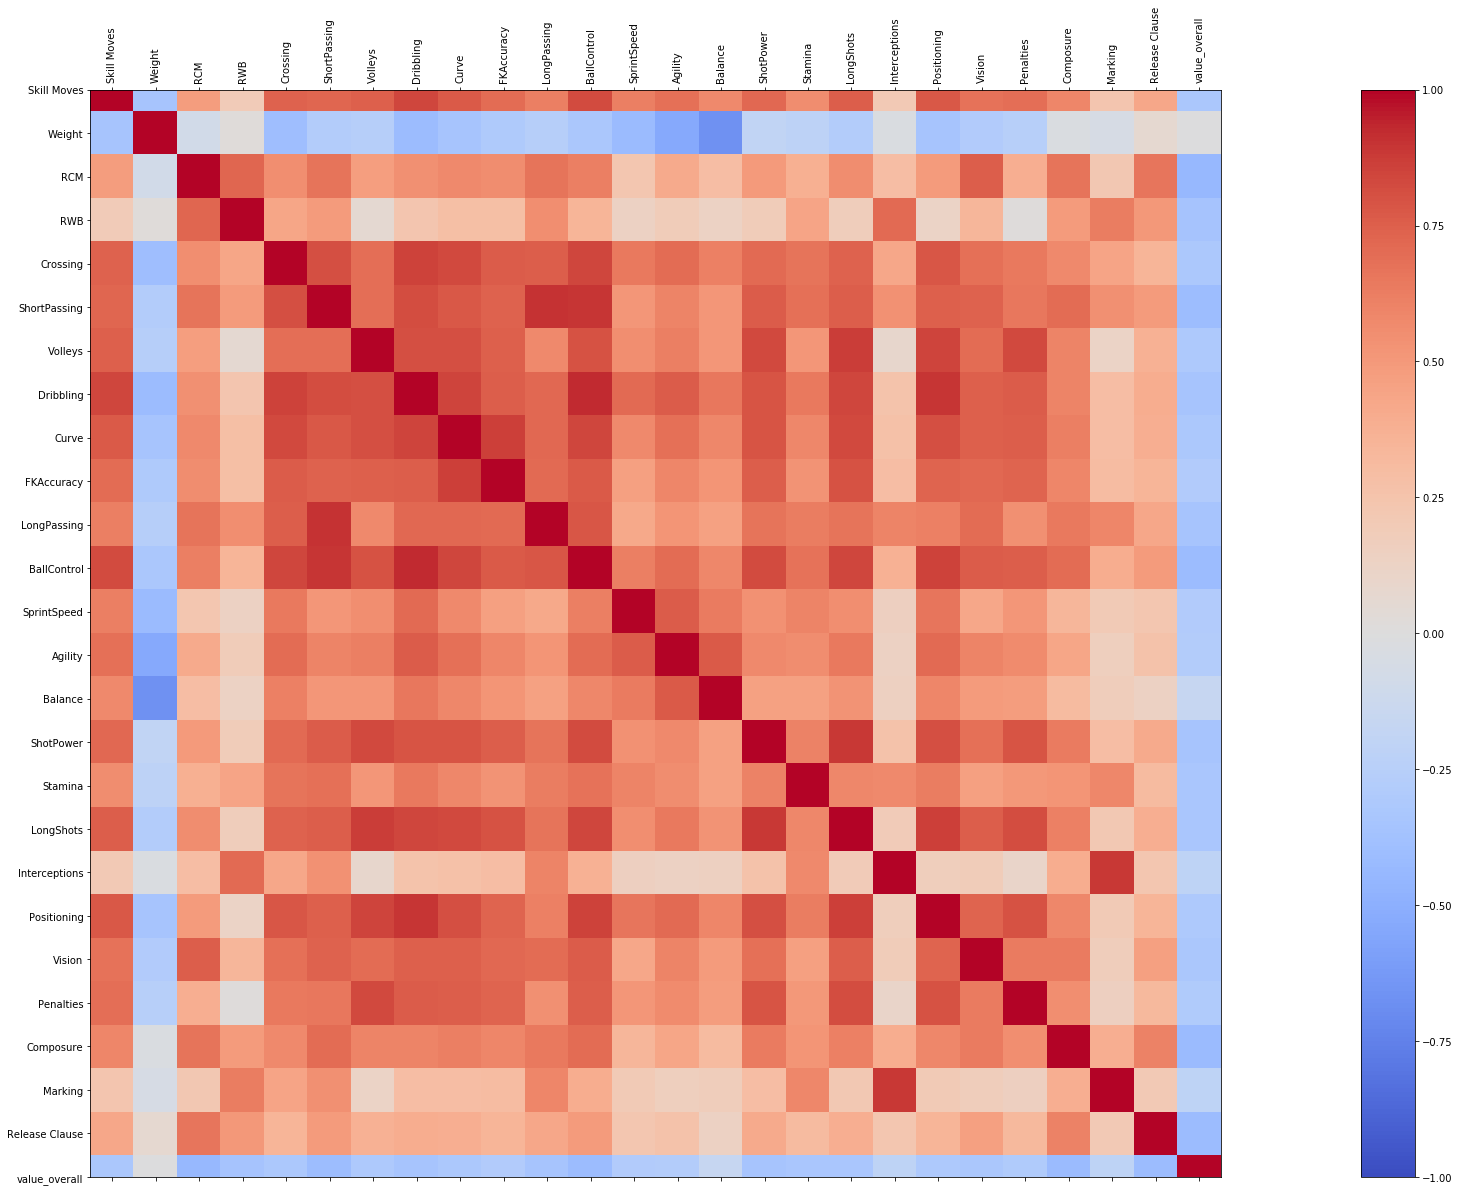

['Skill Moves', 'Weight', 'RCM', 'RWB', 'Crossing', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'SprintSpeed', 'Agility', 'Balance', 'ShotPower', 'Stamina', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'Release Clause', 'value_overall']


In [65]:
corr = fifa19[drop_list].corr()
fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(fifa19[drop_list].columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(fifa19[drop_list].columns)
ax.set_yticklabels(fifa19[drop_list].columns)
plt.show()
drop = ['ST', 'RS', 'LW', 'LF', 'CF', 'RF',
        'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
        'CM', 'RM', 'LDM', 'CDM', 'RDM', 'LB',
        'LCB', 'CB', 'RCB', 'RB', 'StandingTackle', 'SlidingTackle']
drop_list = [ele for ele in drop_list if ele not in drop]
print(drop_list)

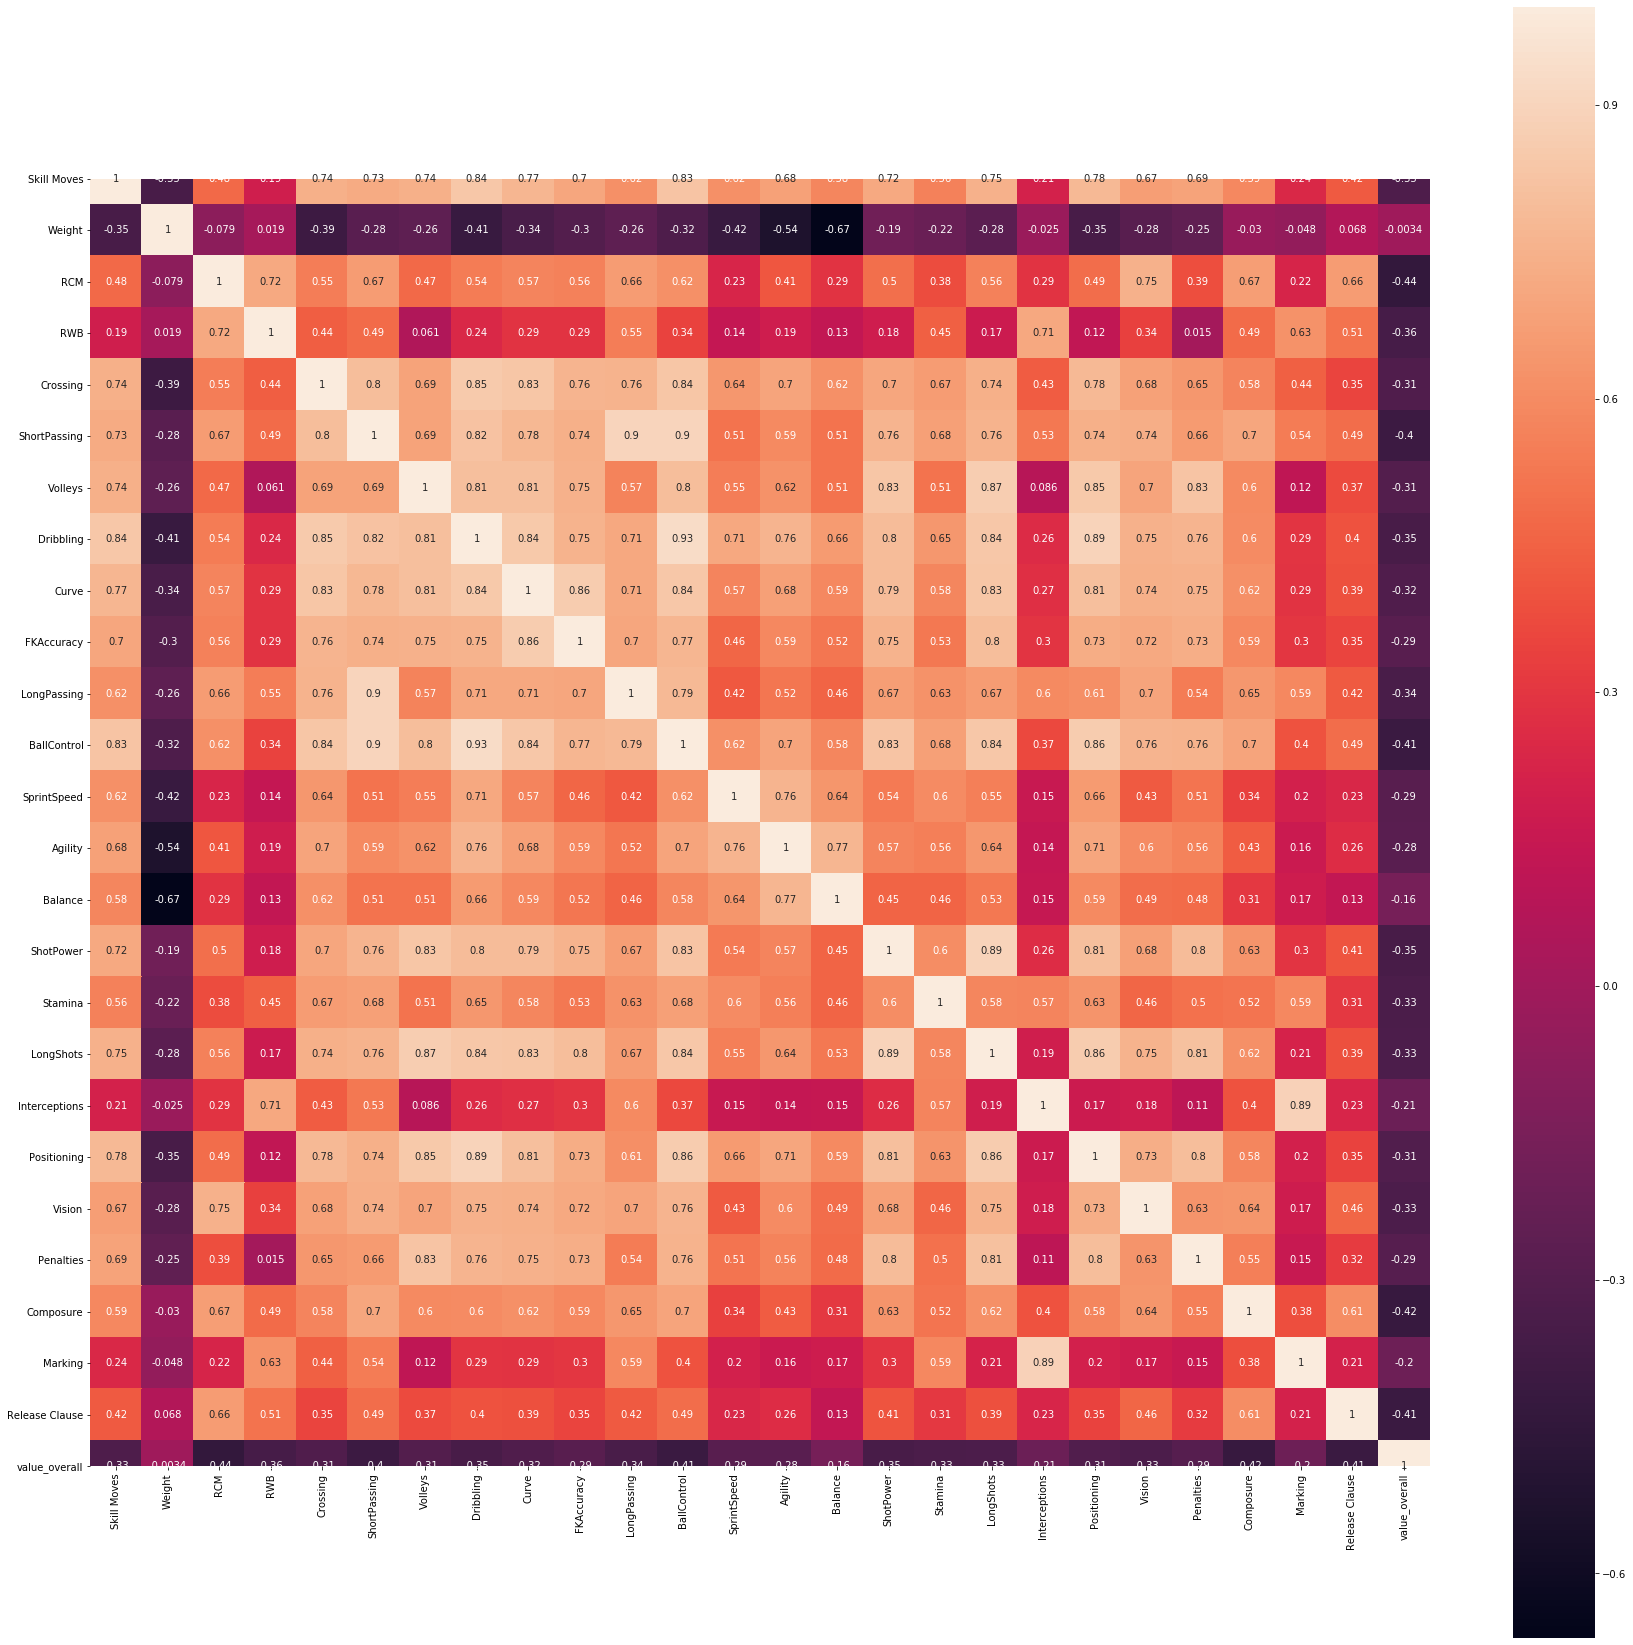

In [67]:
plt.figure(figsize=(30,30))
sns.heatmap(corr, square=True, annot=True)

In [68]:
## I've dropped all the columns with over 90% correlation to each other. 

In [69]:
#X and y assignments
X = fifa19.loc[:, fifa19.columns != 'Value']
X = X.drop(columns='Overall')
X = X.drop(columns='value_overall')
X = X.drop(columns=drop)
y = fifa19['value_overall']
print(X.columns)

Index(['Unnamed: 0', 'Name', 'Age', 'Nationality', 'Potential', 'Club', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight',
       'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],
      dtype='object')


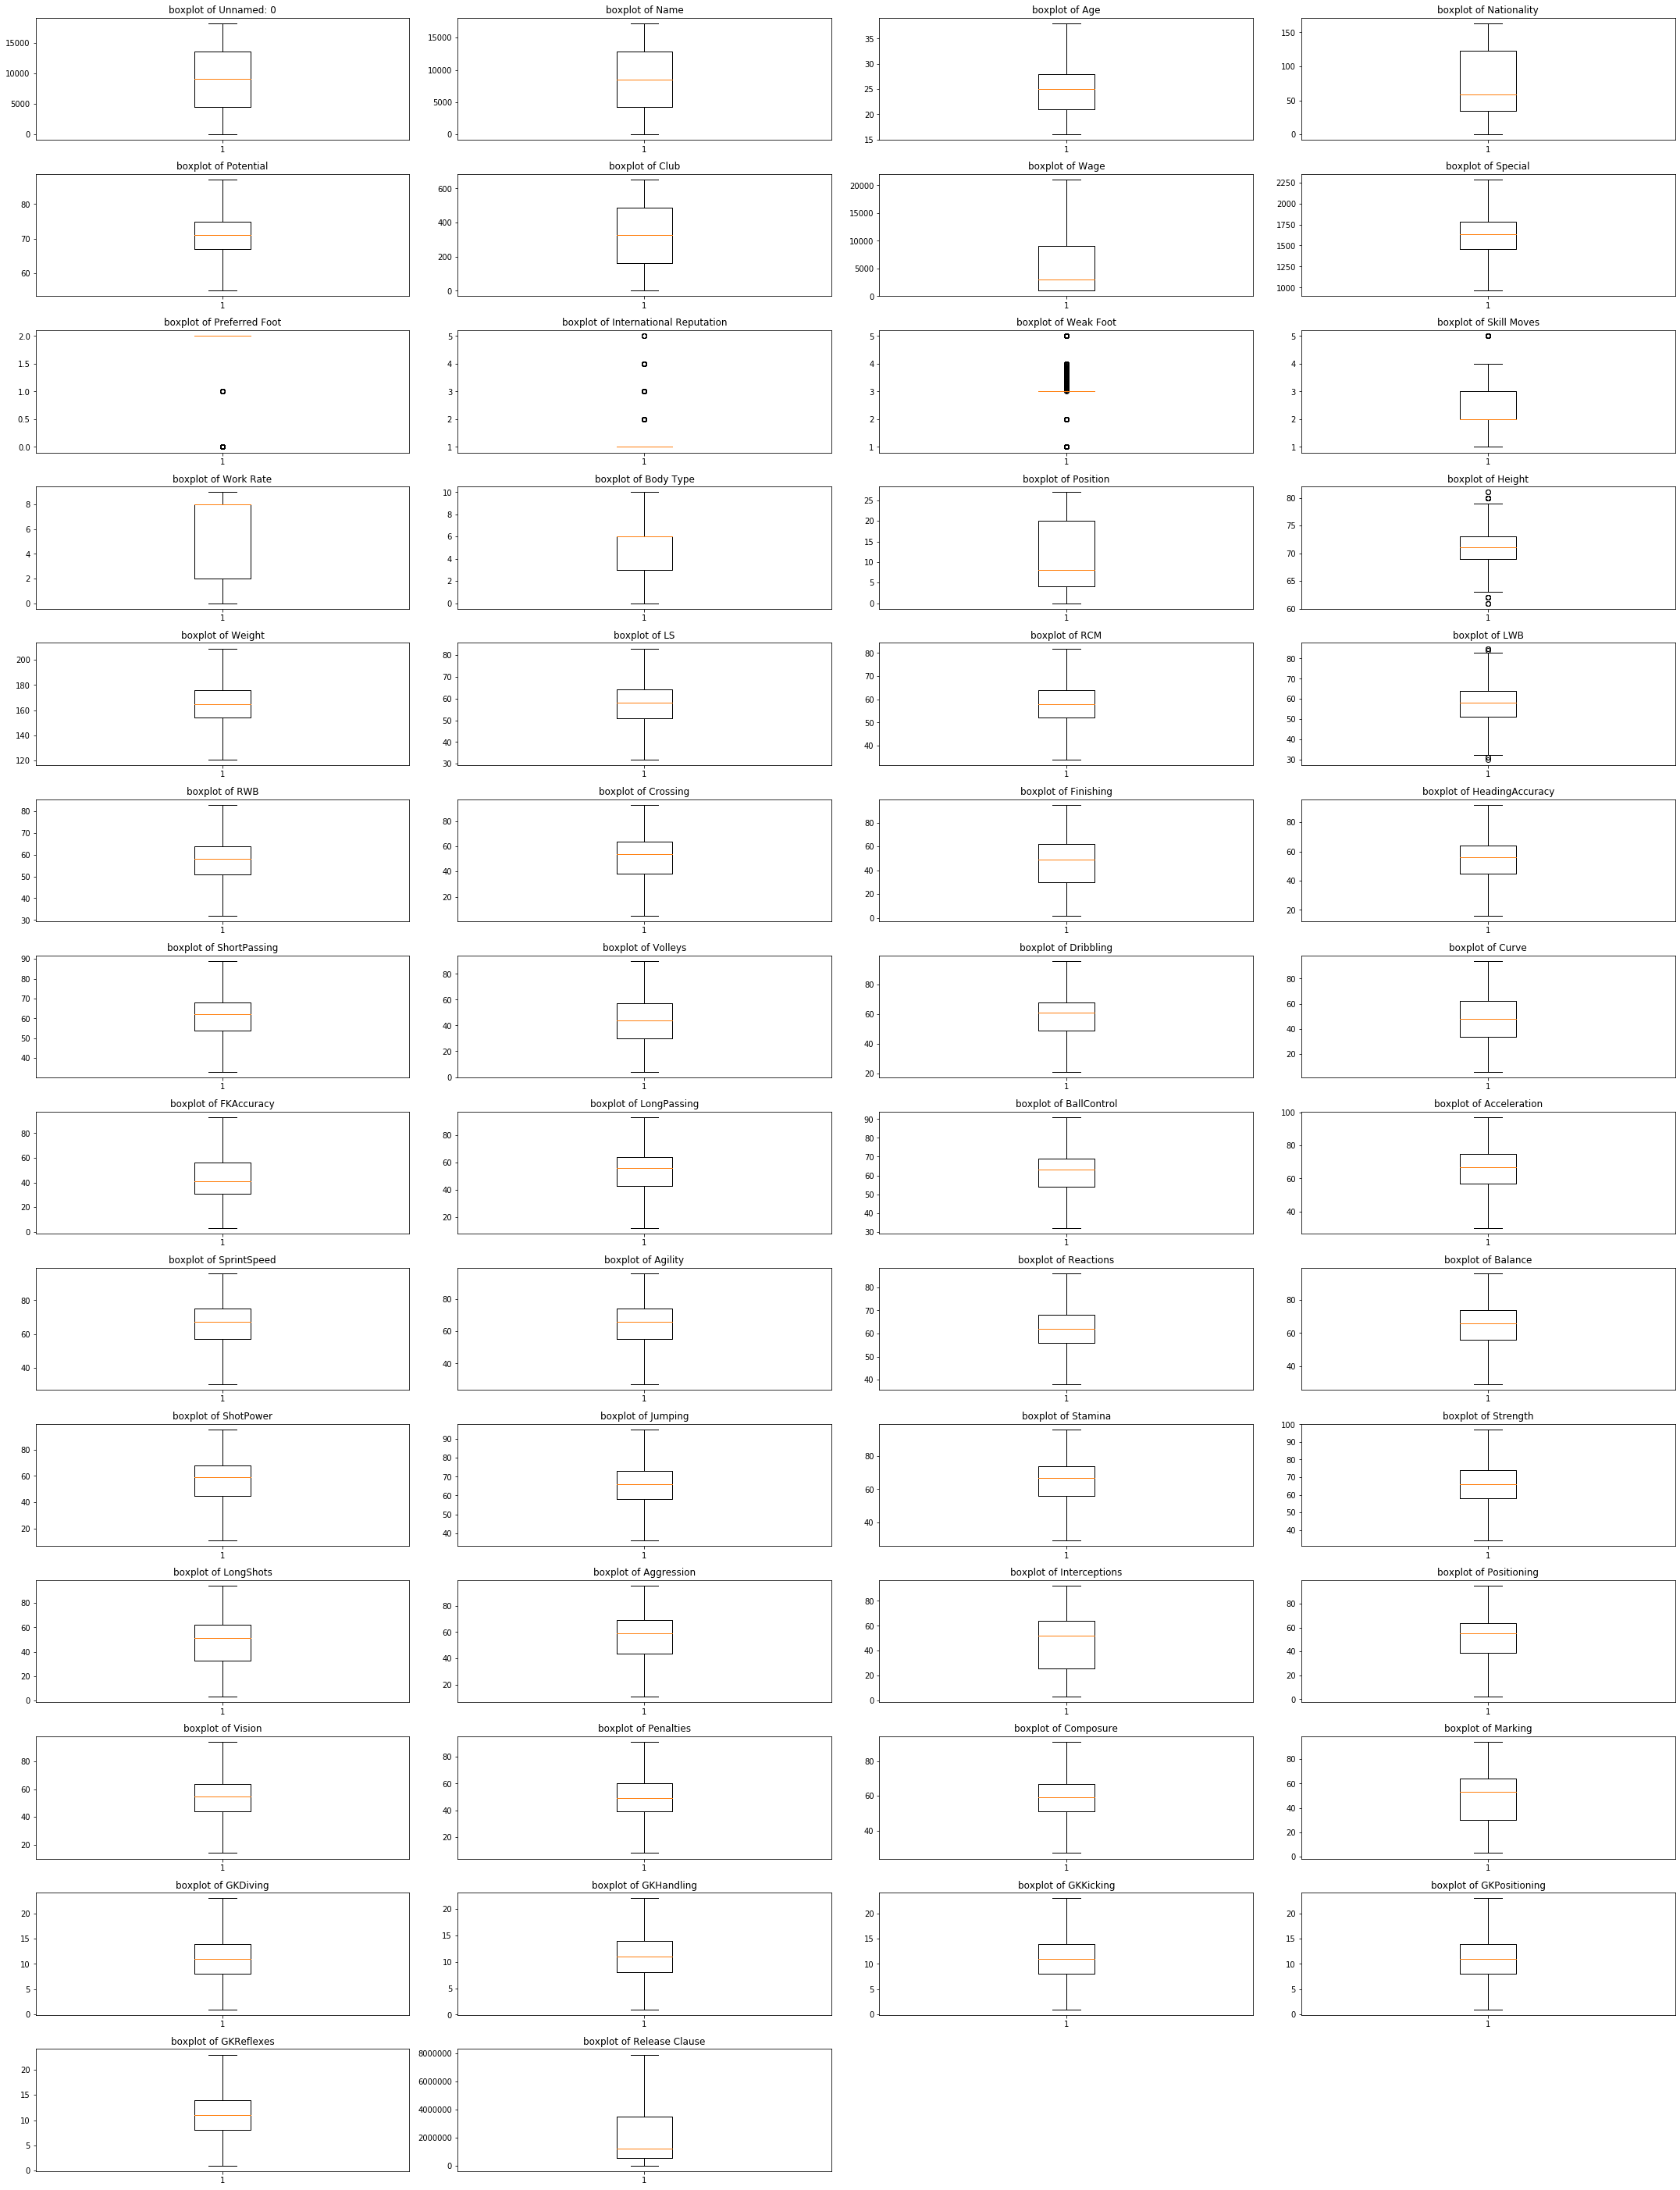

In [70]:
X_cont = X.select_dtypes(exclude='object')
fig = plt.figure(figsize=(30,150))
for i, col in enumerate(X_cont.columns):
    
    plt.subplot(len(X_cont.columns), 4, i+1)
    plt.boxplot(X[col])
    plt.title('boxplot of {}'.format(col))
    plt.tight_layout()


In [71]:
#Looks like I left Name and Unnamed: 0 in there. I'll drop that now
X = X.drop(columns=['Name', 'Unnamed: 0'])

print(list(X.columns))

['Age', 'Nationality', 'Potential', 'Club', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight', 'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']


In [72]:
print(list(X.columns))

['Age', 'Nationality', 'Potential', 'Club', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight', 'LS', 'RCM', 'LWB', 'RWB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']


In [73]:

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
print(X_train.shape)
print(X_test.shape)
# I will now scale my X and Y and start running different models
scaler = preprocessing.StandardScaler()

#X = scaler.fit_transform(X)
y = fifa19['value_overall']

(13466, 52)
(4489, 52)


The number of observations in training set is 13466
The number of observations in test set is 4489


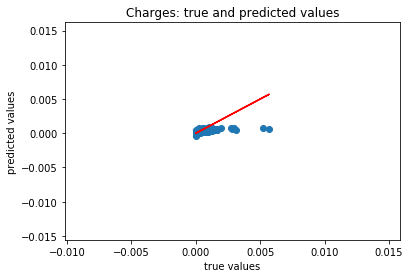

Mean absolute error of the prediction is: 9.629165729293104e-05
Mean squared error of the prediction is: 3.265702953228236e-08
Root mean squared error of the prediction is: 0.0001807125605271597
Mean absolute percentage error of the prediction is: 317.66194490990614


In [74]:
#starting with OLS
results = sm.OLS(y, X).fit()



print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)


# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



In [75]:

results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     228.3
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:29:08   Log-Likelihood:             1.2641e+05
No. Observations:               17955   AIC:                        -2.527e+05
Df Residuals:                   17902   BIC:                        -2.523e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0025   9.72e-05     25.917      0.000       0.002       0.003
Age                       3.779e-06   6.35e-07      5.950      0.000    2.53e-06    5.02e-06
Nationality              -4.457e-08   3.34e-08     -1.333      0.183    -1.1e-07     2.1e-08
Potential                -1.645e-05   5.37e-07    -30.652      0.000   -1.75e-05   -1.54e-05
Club                      8.468e-09   8.45e-09      1.002      0.316    -8.1e-09     2.5e-08
Wage                      4.274e-10   4.26e-10      1.004      0.315   -4.07e-10    1.26e-09
Special                   5.413e-07   1.05e-07      5.179      0.000    3.36e-07    7.46e-07
Preferred Foot            3.306e-06      2e-06      1.655      0.098    -6.1e-07    7.22e-06
International Reputation   8.58e-05   4.87e-06     17.603      0.000    7.62e-05    9.54e-05
Weak Foot                -1.426e-06   2.63e-06     -0.542      0.588   -6.59e-06    3.73e-06
Skill Moves              -1.225e-06   4.28e-06     -0.286      0.775   -9.62e-06    7.17e-06
Work Rate                -1.413e-06   6.22e-07     -2.271      0.023   -2.63e-06   -1.94e-07
Body Type                -5.812e-07   9.67e-07     -0.601      0.548   -2.48e-06    1.31e-06
Position                 -7.243e-07   2.28e-07     -3.174      0.002   -1.17e-06   -2.77e-07
Height                   -2.324e-07   1.24e-06     -0.187      0.851   -2.66e-06     2.2e-06
Weight                   -2.255e-07   1.89e-07     -1.193      0.233   -5.96e-07    1.45e-07
LS                       -5.171e-06   1.05e-06     -4.908      0.000   -7.24e-06   -3.11e-06
RCM                      -5.069e-06   1.44e-06     -3.510      0.000    -7.9e-06   -2.24e-06
LWB                      -1.487e-05    5.5e-05     -0.270      0.787      -0.000     9.3e-05
RWB                       7.841e-06    5.5e-05      0.143      0.887     -0.0001       0.000
Crossing                 -1.516e-07   2.55e-07     -0.596      0.552   -6.51e-07    3.47e-07
Finishing                -3.147e-07   3.06e-07     -1.028      0.304   -9.15e-07    2.85e-07
HeadingAccuracy          -2.567e-06   2.49e-07    -10.288      0.000   -3.06e-06   -2.08e-06
ShortPassing             -4.629e-07   4.62e-07     -1.003      0.316   -1.37e-06    4.42e-07
Volleys                  -6.034e-07   2.52e-07     -2.397      0.017    -1.1e-06    -1.1e-07
Dribbling                 1.292e-06   3.68e-07      3.514      0.000    5.71e-07    2.01e-06
Curve                    -2.946e-07   2.53e-07     -1.163      0.245   -7.91e-07    2.02e-07
FKAccuracy                -9.28e-07   2.33e-07     -3.984      0.000   -1.38e-06   -4.71e-07
LongPassing              -5.829e-07   3.59e-07     -1.621      0.105   -1.29e-06    1.22e-07
BallControl              -2.318e-06   4.75e-07     -4.884      0.000   -3.25e-06   -1.39e-06
Acceleration  

In [76]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
print(X.shape)
print(y.shape)
print(len(X.columns))

(4489, 52)
(13466, 52)
(4489,)
(13466,)
(17955, 53)
(17955,)
53


## I am interested in knowing the time to run these algorithms as well as the performance so I'll use a log time function

In [77]:
import atexit
from time import time, strftime, localtime
from datetime import timedelta

def secondsToStr(elapsed=None):
    if elapsed is None:
        return strftime("%Y-%m-%d %H:%M:%S", localtime())
    else:
        return str(timedelta(seconds=elapsed))

def log(s, elapsed=None):
    line = "="*40
    print(line)
    print(secondsToStr(), '-', s)
    if elapsed:
        print("Elapsed time:", elapsed)
    print(line)
    print()

def endlog():
    end = time()
    elapsed = end-start
    log("End Program", secondsToStr(elapsed))

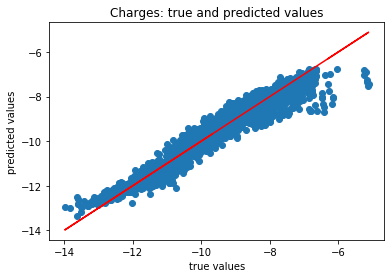

Mean absolute error of the prediction is: 0.24753714956571282
Mean squared error of the prediction is: 0.11410206799756963
Root mean squared error of the prediction is: 0.33778997616502715
Mean absolute percentage error of the prediction is: 2.759307234315848


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     4912.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:29:08   Log-Likelihood:                -5837.4
No. Observations:               17955   AIC:                         1.178e+04
Df Residuals:                   17902   BIC:                         1.219e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0107      0.154      0.069      0.945      -0.291       0.312
Age                          0.0012      0.001      1.214      0.225      -0.001       0.003
Nationality              -8.855e-05   5.29e-05     -1.675      0.094      -0.000    1.51e-05
Potential                   -0.0581      0.001    -68.521      0.000      -0.060      -0.056
Club                      -1.67e-05   1.34e-05     -1.250      0.211   -4.29e-05    9.49e-06
Wage                     -6.894e-06   6.73e-07    -10.243      0.000   -8.21e-06   -5.57e-06
Special                      0.0010      0.000      5.917      0.000       0.001       0.001
Preferred Foot               0.0124      0.003      3.936      0.000       0.006       0.019
International Reputation    -0.0081      0.008     -1.049      0.294      -0.023       0.007
Weak Foot                   -0.0089      0.004     -2.147      0.032      -0.017      -0.001
Skill Moves                 -0.0981      0.007    -14.489      0.000      -0.111      -0.085
Work Rate                   -0.0005      0.001     -0.506      0.613      -0.002       0.001
Body Type                   -0.0039      0.002     -2.583      0.010      -0.007      -0.001
Position                    -0.0018      0.000     -4.986      0.000      -0.003      -0.001
Height                      -0.0011      0.002     -0.575      0.566      -0.005       0.003
Weight                      -0.0014      0.000     -4.658      0.000      -0.002      -0.001
LS                          -0.0159      0.002     -9.518      0.000      -0.019      -0.013
RCM                         -0.0101      0.002     -4.404      0.000      -0.015      -0.006
LWB                         -0.1716      0.087     -1.974      0.048      -0.342      -0.001
RWB                          0.1564      0.087      1.798      0.072      -0.014       0.327
Crossing                     0.0016      0.000      3.954      0.000       0.001       0.002
Finishing                   -0.0015      0.000     -3.093      0.002      -0.002      -0.001
HeadingAccuracy             -0.0053      0.000    -13.428      0.000      -0.006      -0.005
ShortPassing                -0.0053      0.001     -7.265      0.000      -0.007      -0.004
Volleys                     -0.0012      0.000     -3.000      0.003      -0.002      -0.000
Dribbling                    0.0056      0.001      9.577      0.000       0.004       0.007
Curve                       -0.0002      0.000     -0.450      0.653      -0.001       0.001
FKAccuracy                  -0.0027      0.000     -7.340      0.000      -0.003      -0.002
LongPassing                 -0.0003      0.001     -0.572      0.567      -0.001       0.001
BallControl                 -0.0093      0.001    -12.451      0.000      -0.011      -0.008
Acceleration  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.528
Model:                            OLS   Adj. R-squared (uncentered):              0.526
Method:                 Least Squares   F-statistic:                              288.3
Date:                Tue, 17 Dec 2019   Prob (F-statistic):                        0.00
Time:                        18:29:08   Log-Likelihood:                          93931.
No. Observations:               13466   AIC:                                 -1.878e+05
Df Residuals:                   13414   BIC:                                 -1.874e+05
Df Model:                          52                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Age                       9.706e-06   7.45e-07     13.020      0.000    8.24e-06    1.12e-05
Nationality              -4.352e-08   4.12e-08     -1.057      0.291   -1.24e-07    3.72e-08
Potential                -1.125e-05   6.17e-07    -18.213      0.000   -1.25e-05      -1e-05
Club                      8.004e-09   1.04e-08      0.767      0.443   -1.25e-08    2.85e-08
Wage                     -3.621e-10   5.23e-10     -0.693      0.489   -1.39e-09    6.63e-10
Special                   6.835e-07    1.3e-07      5.263      0.000    4.29e-07    9.38e-07
Preferred Foot            6.827e-06   2.45e-06      2.786      0.005    2.02e-06    1.16e-05
International Reputation  7.332e-05   6.02e-06     12.184      0.000    6.15e-05    8.51e-05
Weak Foot                  -4.8e-07   3.25e-06     -0.148      0.882   -6.84e-06    5.88e-06
Skill Moves              -8.463e-07   5.29e-06     -0.160      0.873   -1.12e-05    9.53e-06
Work Rate                -5.475e-07   7.68e-07     -0.713      0.476   -2.05e-06    9.58e-07
Body Type                  4.14e-06   1.17e-06      3.547      0.000    1.85e-06    6.43e-06
Position                 -6.696e-07   2.81e-07     -2.383      0.017   -1.22e-06   -1.19e-07
Height                    2.684e-05   8.14e-07     32.989      0.000    2.52e-05    2.84e-05
Weight                   -6.961e-07   2.32e-07     -3.001      0.003   -1.15e-06   -2.42e-07
LS                       -5.782e-06   1.29e-06     -4.477      0.000   -8.31e-06   -3.25e-06
RCM                      -8.343e-06   1.78e-06     -4.674      0.000   -1.18e-05   -4.84e-06
LWB                         -0.0002   8.59e-05     -1.778      0.075      -0.000    1.57e-05
RWB                          0.0001   8.59e-05      1.698      0.090   -2.25e-05       0.000
Crossing                 -2.088e-07   3.13e-07     -0.666      0.505   -8.23e-07    4.05e-07
Finishing                -4.218e-07   3.76e-07     -1.123      0.261   -1.16e-06    3.14e-07
HeadingAccuracy          -3.114e-06   3.07e-07    -10.137      0.000   -3.72e-06   -2.51e-06
ShortPassing              6.039e-07   5.66e-07      1.066      0.286   -5.07e-07    1.71e-06
Volleys                  -1.229e-06    3.1e-07     -3.960      0.000   -1.84e-06    -6.2e-07
Dribbling                 1.982e-06   4.49e-07      4.419      0.000     1.1e-06    2.86e-06
Curve                    -6.758e-07   3.11e-07     -2.176      0.030   -1.28e-06   -6.69e-08
FKAccuracy               -9.806e-07   2.87e-07     -3.422      0.001   -1.54e-06   -4.19e-07
LongPassing              -5.356e-07   4.43e-07     -1.209      0.227    -1.4e-06    3.33e-07
BallControl              -2.605e-06   5.81e-07     -4.487      0.000   -3.74e-06   -1.47e-06
Accelera

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          value_overall   R-squared (uncentered):                   0.619
Model:                            OLS   Adj. R-squared (uncentered):              0.615
Method:                 Least Squares   F-statistic:                              138.6
Date:                Tue, 17 Dec 2019   Prob (F-statistic):                        0.00
Time:                        18:29:08   Log-Likelihood:                          32356.
No. Observations:                4489   AIC:                                 -6.461e+04
Df Residuals:                    4437   BIC:                                 -6.427e+04
Df Model:                          52                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Age                       6.937e-06   1.03e-06      6.766      0.000    4.93e-06    8.95e-06
Nationality              -4.705e-08   5.74e-08     -0.820      0.412    -1.6e-07    6.54e-08
Potential                -1.201e-05   8.55e-07    -14.053      0.000   -1.37e-05   -1.03e-05
Club                      1.778e-08   1.43e-08      1.239      0.215   -1.03e-08    4.59e-08
Wage                      -4.15e-10   7.28e-10     -0.570      0.569   -1.84e-09    1.01e-09
Special                   7.262e-07   1.74e-07      4.184      0.000    3.86e-07    1.07e-06
Preferred Foot            4.065e-06   3.45e-06      1.177      0.239   -2.71e-06    1.08e-05
International Reputation  8.693e-05   8.26e-06     10.526      0.000    7.07e-05       0.000
Weak Foot                 1.088e-06   4.48e-06      0.243      0.808    -7.7e-06    9.87e-06
Skill Moves               -6.18e-06   7.28e-06     -0.849      0.396   -2.05e-05    8.09e-06
Work Rate                -1.382e-07   1.05e-06     -0.131      0.896    -2.2e-06    1.93e-06
Body Type                 6.094e-06   1.61e-06      3.784      0.000    2.94e-06    9.25e-06
Position                 -6.046e-07   3.92e-07     -1.541      0.123   -1.37e-06    1.65e-07
Height                    2.713e-05   1.15e-06     23.613      0.000    2.49e-05    2.94e-05
Weight                   -8.534e-07   3.21e-07     -2.655      0.008   -1.48e-06   -2.23e-07
LS                       -6.814e-06   1.84e-06     -3.712      0.000   -1.04e-05   -3.21e-06
RCM                      -1.558e-06   2.45e-06     -0.636      0.525   -6.36e-06    3.24e-06
LWB                       9.043e-05   6.47e-05      1.398      0.162   -3.64e-05       0.000
RWB                      -9.857e-05   6.47e-05     -1.524      0.128      -0.000    2.83e-05
Crossing                 -1.198e-07   4.39e-07     -0.273      0.785    -9.8e-07     7.4e-07
Finishing                -6.215e-07   5.32e-07     -1.168      0.243   -1.66e-06    4.21e-07
HeadingAccuracy          -2.744e-06   4.24e-07     -6.472      0.000   -3.57e-06   -1.91e-06
ShortPassing             -9.346e-07   7.96e-07     -1.175      0.240   -2.49e-06    6.25e-07
Volleys                  -2.607e-07   4.28e-07     -0.609      0.542    -1.1e-06    5.78e-07
Dribbling                 5.875e-07   6.49e-07      0.905      0.366   -6.85e-07    1.86e-06
Curve                    -5.384e-07   4.38e-07     -1.228      0.219    -1.4e-06    3.21e-07
FKAccuracy               -9.501e-07   4.02e-07     -2.365      0.018   -1.74e-06   -1.63e-07
LongPassing              -6.818e-07   6.17e-07     -1.105      0.269   -1.89e-06    5.28e-07
BallControl              -1.222e-06   8.32e-07     -1.468      0.142   -2.85e-06     4.1e-07
Accelera

2019-12-17 18:29:09 - OLS
Elapsed time: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c207d50f0>

2019-12-17 18:29:09 - End Program
Elapsed time: 0:00:00.124629



In [78]:
y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results_train = sm.OLS(y_train, X_train).fit()
results_test = sm.OLS(y_test, X_test).fit()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())
display(results_train.summary())
display(results_test.summary())

#checking time to run model
start = time()
atexit.register(endlog)
log('OLS', sm.OLS(y,X).fit())
endlog()


some variables have very high p values. I am going to start with dropping all p values over .100

In [79]:
X = X.drop(columns=['GKPositioning', 'GKKicking', 'GKHandling', 'Penalties',
                    'Balance', 'LongPassing', 'Curve', 'International Reputation', 
                    'Age', 'Club', 'ShotPower', 'Work Rate'])

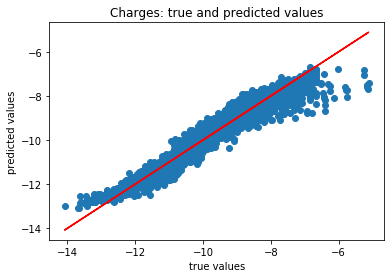

Mean absolute error of the prediction is: 0.24752814860199313
Mean squared error of the prediction is: 0.11601903599497583
Root mean squared error of the prediction is: 0.3406156719749927
Mean absolute percentage error of the prediction is: 2.7714870379575784


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     6385.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:29:09   Log-Likelihood:                -5844.0
No. Observations:               17955   AIC:                         1.177e+04
Df Residuals:                   17914   BIC:                         1.209e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2228      0.130      1.710      0.087      -0.033       0.478
Nationality     -8.869e-05   5.27e-05     -1.682      0.093      -0.000    1.47e-05
Potential          -0.0587      0.001    -90.786      0.000      -0.060      -0.057
Wage            -6.823e-06    6.6e-07    -10.337      0.000   -8.12e-06   -5.53e-06
Special             0.0009      0.000      7.987      0.000       0.001       0.001
Preferred Foot      0.0123      0.003      3.911      0.000       0.006       0.018
Weak Foot          -0.0086      0.004     -2.073      0.038      -0.017      -0.000
Skill Moves        -0.0975      0.007    -14.468      0.000      -0.111      -0.084
Body Type          -0.0037      0.002     -2.452      0.014      -0.007      -0.001
Position           -0.0018      0.000     -5.025      0.000      -0.003      -0.001
Height             -0.0032      0.002     -1.784      0.074      -0.007       0.000
Weight             -0.0014      0.000     -4.867      0.000      -0.002      -0.001
LS                 -0.0160      0.001    -11.578      0.000      -0.019      -0.013
RCM                -0.0100      0.002     -5.391      0.000      -0.014      -0.006
LWB                -0.1719      0.087     -1.980      0.048      -0.342      -0.002
RWB                 0.1571      0.087      1.809      0.071      -0.013       0.327
Crossing            0.0016      0.000      4.200      0.000       0.001       0.002
Finishing          -0.0014      0.000     -3.031      0.002      -0.002      -0.001
HeadingAccuracy    -0.0053      0.000    -14.195      0.000      -0.006      -0.005
ShortPassing       -0.0055      0.001     -7.746      0.000      -0.007      -0.004
Volleys            -0.0012      0.000     -3.056      0.002      -0.002      -0.000
Dribbling           0.0056      0.001      9.873      0.000       0.004       0.007
FKAccuracy         -0.0027      0.000     -7.821      0.000      -0.003      -0.002
BallControl        -0.0093      0.001    -12.653      0.000      -0.011      -0.008
Acceleration       -0.0037      0.001     -6.950      0.000      -0.005      -0.003
SprintSpeed        -0.0037      0.000     -7.433      0.000      -0.005      -0.003
Agility            -0.0027      0.000     -6.921      0.000      -0.003      -0.002
Reactions          -0.0165      0.001    -30.336      0.000      -0.018      -0.015
Jumping            -0.0012      0.000     -3.963      0.000      -0.002      -0.001
Stamina            -0.0053      0.000    -15.962      0.000      -0.006      -0.005
Strength           -0.0057      0.000    -14.867      0.000      -0.006      -0.005
LongShots           0.0007      0.000      1.667      0.096      -0.000       0.001
Aggression          0.0008      0.000      2.634      0.008       0.000       0.001
Interceptions       0.0026      0.000      6.431      0.000

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     3691.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:29:09   Log-Likelihood:                -4331.8
No. Observations:               13466   AIC:                             8770.
Df Residuals:                   13413   BIC:                             9168.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0354      0.178      0.199      0.843      -0.314       0.384
Age                          0.0007      0.001      0.604      0.546      -0.002       0.003
Nationality                -8.6e-05   6.09e-05     -1.412      0.158      -0.000    3.34e-05
Potential                   -0.0582      0.001    -59.586      0.000      -0.060      -0.056
Club                     -1.239e-05   1.54e-05     -0.807      0.420   -4.25e-05    1.77e-05
Wage                     -6.739e-06   7.78e-07     -8.659      0.000   -8.26e-06   -5.21e-06
Special                      0.0013      0.000      6.902      0.000       0.001       0.002
Preferred Foot               0.0157      0.004      4.330      0.000       0.009       0.023
International Reputation    -0.0107      0.009     -1.204      0.229      -0.028       0.007
Weak Foot                   -0.0092      0.005     -1.920      0.055      -0.019       0.000
Skill Moves                 -0.0942      0.008    -12.080      0.000      -0.109      -0.079
Work Rate                   -0.0008      0.001     -0.662      0.508      -0.003       0.001
Body Type                   -0.0035      0.002     -1.968      0.049      -0.007   -1.35e-05
Position                    -0.0014      0.000     -3.490      0.000      -0.002      -0.001
Height                      -0.0022      0.002     -0.983      0.326      -0.007       0.002
Weight                      -0.0011      0.000     -3.261      0.001      -0.002      -0.000
LS                          -0.0195      0.002     -9.985      0.000      -0.023      -0.016
RCM                         -0.0055      0.003     -2.085      0.037      -0.011      -0.000
LWB                         -0.1082      0.127     -0.852      0.394      -0.357       0.141
RWB                          0.0896      0.127      0.705      0.481      -0.159       0.339
Crossing                     0.0016      0.000      3.349      0.001       0.001       0.002
Finishing                   -0.0012      0.001     -2.116      0.034      -0.002    -8.7e-05
HeadingAccuracy             -0.0053      0.000    -11.701      0.000      -0.006      -0.004
ShortPassing                -0.0059      0.001     -6.952      0.000      -0.008      -0.004
Volleys                     -0.0017      0.000     -3.751      0.000      -0.003      -0.001
Dribbling                    0.0048      0.001      7.122      0.000       0.003       0.006
Curve                       -0.0003      0.000     -0.663      0.507      -0.001       0.001
FKAccuracy                  -0.0031      0.000     -7.337      0.000      -0.004      -0.002
LongPassing                 -0.0013      0.001     -2.002      0.045      -0.003   -2.78e-05
BallControl                 -0.0094      0.001    -10.792      0.000      -0.011      -0.008
Acceleration  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_overall   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1224.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:29:09   Log-Likelihood:                -1475.9
No. Observations:                4489   AIC:                             3058.
Df Residuals:                    4436   BIC:                             3398.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0652      0.306     -0.213      0.831      -0.665       0.534
Age                          0.0029      0.002      1.428      0.153      -0.001       0.007
Nationality              -8.797e-05      0.000     -0.822      0.411      -0.000       0.000
Potential                   -0.0580      0.002    -33.714      0.000      -0.061      -0.055
Club                     -2.784e-05   2.72e-05     -1.024      0.306   -8.11e-05    2.54e-05
Wage                     -7.346e-06   1.35e-06     -5.452      0.000   -9.99e-06    -4.7e-06
Special                    8.91e-06      0.000      0.029      0.977      -0.001       0.001
Preferred Foot               0.0029      0.006      0.456      0.648      -0.010       0.015
International Reputation    -0.0001      0.015     -0.009      0.993      -0.030       0.030
Weak Foot                   -0.0114      0.009     -1.336      0.182      -0.028       0.005
Skill Moves                 -0.1107      0.014     -8.052      0.000      -0.138      -0.084
Work Rate                    0.0004      0.002      0.185      0.854      -0.004       0.004
Body Type                   -0.0060      0.003     -1.931      0.053      -0.012    9.03e-05
Position                    -0.0029      0.001     -3.925      0.000      -0.004      -0.001
Height                       0.0021      0.004      0.546      0.585      -0.006       0.010
Weight                      -0.0021      0.001     -3.424      0.001      -0.003      -0.001
LS                          -0.0062      0.003     -1.911      0.056      -0.012       0.000
RCM                         -0.0232      0.005     -5.035      0.000      -0.032      -0.014
LWB                         -0.2188      0.121     -1.815      0.070      -0.455       0.018
RWB                          0.2136      0.121      1.772      0.076      -0.023       0.450
Crossing                     0.0014      0.001      1.760      0.078      -0.000       0.003
Finishing                   -0.0022      0.001     -2.274      0.023      -0.004      -0.000
HeadingAccuracy             -0.0053      0.001     -6.625      0.000      -0.007      -0.004
ShortPassing                -0.0038      0.001     -2.645      0.008      -0.007      -0.001
Volleys                      0.0003      0.001      0.404      0.687      -0.001       0.002
Dribbling                    0.0080      0.001      6.838      0.000       0.006       0.010
Curve                     6.706e-05      0.001      0.084      0.933      -0.001       0.002
FKAccuracy                  -0.0015      0.001     -2.044      0.041      -0.003   -6.08e-05
LongPassing                  0.0024      0.001      2.121      0.034       0.000       0.005
BallControl                 -0.0090      0.001     -6.163      0.000      -0.012      -0.006
Acceleration  

2019-12-17 18:29:10 - OLS
Elapsed time: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c223f8b70>

2019-12-17 18:29:10 - End Program
Elapsed time: 0:00:00.065997



In [80]:
y = np.log(fifa19.value_overall)
results = sm.OLS(y, X).fit()
results_train = sm.OLS(y_train, X_train).fit()
results_test = sm.OLS(y_test, X_test).fit()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

display(results.summary())
display(results_train.summary())
display(results_test.summary())

#checking time to run model
start = time()
atexit.register(endlog)
log('OLS', sm.OLS(y,X).fit())
endlog()


In [92]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
print(cross_val_score(rfr, X_train, y_train, cv=10))
print(rfr.score(X_test, y_test))

#checking time to run model
start = time()
atexit.register(endlog)
log('rfr', rfr.fit(X,y))
endlog()


[0.98433079 0.98187243 0.98512408 0.98433302 0.98406397 0.98024536
 0.98541101 0.98486206 0.98546561 0.98286948]
0.9851762072110508
2019-12-17 20:06:00 - rfr
Elapsed time: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

2019-12-17 20:06:00 - End Program
Elapsed time: 0:00:33.263722



In [83]:
print(X.shape)

(17955, 41)


In [87]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)

print(knn.score(X_test,y_test))
print(cross_val_score(knn, X_train, y_train, cv=10))

#print(knn.score(X_train, y_train))
#print(knn.score(X_test, y_test))
#y_pred = knn.predict(X_test)

#checking time to run model
start = time()
atexit.register(endlog)
log('knn', knn.fit(X,y))
endlog()


0.9693276261417559
[0.9652579  0.96466283 0.96703461 0.97019821 0.9680397  0.9681808
 0.96664465 0.9644731  0.96885508 0.96453258]
2019-12-17 18:57:44 - knn
Elapsed time: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

2019-12-17 18:57:44 - End Program
Elapsed time: 0:00:00.145734



In [91]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train,y_train).score(X,y)

print(cross_val_score(svr, X_train, y_train, cv=10))
print(svr.score(X_test, y_test))


#checking time to run model
start = time()
atexit.register(endlog)
log('svr', svr.fit(X,y))
endlog()

[-0.00783724 -0.00965542 -0.00468822 -0.00255692 -0.00303988 -0.00415841
 -0.0050707  -0.01790055 -0.0029294  -0.01144175]
-0.004055643863033254
2019-12-17 19:38:35 - svr
Elapsed time: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

2019-12-17 19:38:35 - End Program
Elapsed time: 0:00:59.617055

